In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from string import punctuation
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,confusion_matrix

[nltk_data] Downloading package stopwords to /home/kvats/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kvats/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/kvats/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
first_n_words = 200
def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x

In [3]:
def dataset_split(path='raw/',ratio=(0.7,0.15,0.15))->pd.DataFrame:
    """split raw csv files into train, validation and test sets

    Args:
        path (str, optional): path of raw files. Defaults to '../raw/'.
        ratio (tuple, optional): splitting ratio. Defaults to (0.7,0.15,0.15).

    Returns:
        pd.DataFrame: train, validation and test sets
    """    
    assert sum(ratio)==1.0 and len(ratio)==3, "ratio error"
    true_df = pd.read_csv(path+'Fake.csv')
    fake_df = pd.read_csv(path+'True.csv')
    true_df["label"] = 1
    fake_df["label"] = 0
    df = pd.concat([true_df, fake_df], ignore_index=True)
    df['titletext'] = df['title'] + ". " + df['text']
    df['text'] = df['text'].apply(trim_string)
    df['titletext'] = df['titletext'].apply(trim_string) 
    df = df.reindex(columns=['label', 'title', 'text', 'titletext'])
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    train_df, temp_df = train_test_split(df, test_size=ratio[2]+ratio[1], random_state=42, stratify=df["label"])
    val_df, test_df = train_test_split(temp_df, test_size=ratio[2]/(ratio[2]+ratio[1]), random_state=42, stratify=temp_df["label"])
    return train_df,val_df,test_df

In [4]:
os.chdir('..')
os.getcwd()

'/home/kvats/private/nw/ECE-143-Final-Project'

In [5]:
import sys
sys.path.append('src')

In [6]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries
# from torchtext import _extension
# from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

cuda:0


/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Model parameters
MAX_SEQ_LEN = 128
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

PAD_INDEX = tokenizer.pad_token_id
UNK_INDEX = tokenizer.unk_token_id

# Load CSV Data
train_df, valid_df, test_df = dataset_split(ratio = (0.1, 0.1, 0.8))
# Just

# Custom Dataset Class
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.labels = df["label"].values
        self.texts = df["text"].values
        self.titles = df["title"].values
        self.titletexts = df["titletext"].values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        # Tokenize text, title, and titletext
        encoded_text = self.tokenizer(self.texts[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        encoded_title = self.tokenizer(self.titles[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        encoded_titletext = self.tokenizer(self.titletexts[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")

        return {
            "label": label,
            "text": encoded_text["input_ids"].squeeze(0),
            "title": encoded_title["input_ids"].squeeze(0),
            "titletext": encoded_titletext["input_ids"].squeeze(0),
        }

# Create Dataset Objects
train_dataset = TextDataset(train_df, tokenizer, MAX_SEQ_LEN)
valid_dataset = TextDataset(valid_df, tokenizer, MAX_SEQ_LEN)
test_dataset = TextDataset(test_df, tokenizer, MAX_SEQ_LEN)

# Collate Function for Padding & Sorting (Optional)
def collate_fn(batch):
    labels = torch.stack([item["label"] for item in batch])
    texts = torch.stack([item["text"] for item in batch])
    titles = torch.stack([item["title"] for item in batch])
    titletexts = torch.stack([item["titletext"] for item in batch])
    
    return {"label": labels, "text": texts, "title": titles, "titletext": titletexts}

# Create DataLoaders (Replacing BucketIterator)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Example Batch
for batch in train_loader:
    print(batch["text"].shape)  # Expected: (batch_size, MAX_SEQ_LEN)
    print(batch["label"].shape) # Expected: (batch_size,)
    break

/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


       label                                              title  \
29528      1  “SHE’S NO PUSHOVER”: How Sarah Huckabee Sander...   
13884      0  Macedonia's largest opposition party appoints ...   
21642      1  Trump’s Disastrously-Misspelled Terrorist Atta...   
12207      0  Three Turkish soldiers killed in southeast: mi...   
6972       0  'Nearly man' Ramaphosa edges closer to South A...   

                                                    text  \
29528  Deputy Press Secretary Sarah Huckabee Sanders ...   
13884  House Republicans leaders on Monday embraced a...   
21642  When Trump s White House released a list of te...   
12207  FOX News Catherine Herridge exposes the dirty ...   
6972   The University of Chicago s admissions office ...   

                                               titletext  
29528  “SHE’S NO PUSHOVER”: How Sarah Huckabee Sander...  
13884  Macedonia's largest opposition party appoints ...  
21642  Trump’s Disastrously-Misspelled Terrorist Atta...  


In [22]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        def forward(self, text, label=None):
            if label is not None:
                # Training mode with labels
                loss, text_fea = self.encoder(text, labels=label)[:2]
                return loss, text_fea
            else:
                # Inference mode without labels
                output = self.encoder(text)
                return output.logits

In [11]:
def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [12]:
import torch
import torch.nn as nn

def train(model,
          optimizer,
          criterion=nn.BCELoss(),
          train_loader=None,
          valid_loader=None,
          num_epochs=5,
          eval_every=None,
          file_path="./",
          best_valid_loss=float("Inf")):
    
    # Initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)

    # Set evaluation interval if not provided
    if eval_every is None:
        eval_every = len(train_loader) // 2

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            labels = batch["label"].type(torch.LongTensor)
            titletext = batch["titletext"].type(torch.LongTensor) 
            labels = labels.to(device)
            titletext = titletext.to(device)

            # Forward pass
            output = model(titletext, labels)
            loss, _ = output  # Assuming model returns (loss, logits)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()
            global_step += 1

            # Evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():  
                    valid_running_loss = 0.0  

                    for batch in valid_loader:
                        labels = batch["label"].type(torch.LongTensor)
                        titletext = batch["titletext"].type(torch.LongTensor) 
                        labels = labels.to(device)
                        titletext = titletext.to(device)
                        
                        output = model(titletext, labels)
                        loss, _ = output  
                        
                        valid_running_loss += loss.item()

                # Compute average losses
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # Reset running losses
                running_loss = 0.0
                model.train()

                # Print progress
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{global_step}/{num_epochs * len(train_loader)}], "
                      f"Train Loss: {average_train_loss:.4f}, Valid Loss: {average_valid_loss:.4f}")

                # Save best model
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(f"{file_path}/model.pt", model, best_valid_loss)
                    save_metrics(f"{file_path}/metrics.pt", train_loss_list, valid_loss_list, global_steps_list)

    # Save final metrics
    save_metrics(f"{file_path}/metrics.pt", train_loss_list, valid_loss_list, global_steps_list)
    print("Finished Training!")

In [13]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch [1/5], Step [105/1055], Train Loss: 0.4112, Valid Loss: 0.0728
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [1/5], Step [210/1055], Train Loss: 0.0576, Valid Loss: 0.0316
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [2/5], Step [315/1055], Train Loss: 0.0289, Valid Loss: 0.0370
Epoch [2/5], Step [420/1055], Train Loss: 0.0227, Valid Loss: 0.1027
Epoch [3/5], Step [525/1055], Train Loss: 0.0071, Valid Loss: 0.0405
Epoch [3/5], Step [630/1055], Train Loss: 0.0164, Valid Loss: 0.0322
Epoch [4/5], Step [735/1055], Train Loss: 0.0024, Valid Loss: 0.0808
Epoch [4/5], Step [840/1055], Train Loss: 0.0177, Valid Loss: 0.0165
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [5/5], Step [945/1055], Train Loss: 0.0023, Valid Loss: 0.0248
Epoch [5/5], Step [1050/1055], Train Loss: 0.0006, Valid Loss: 0.0252
Model saved to ==> .//metrics.pt
Finished Training!


Model loaded from <== .//metrics.pt


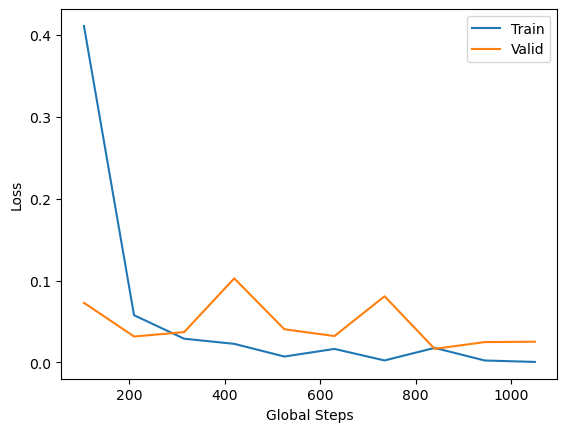

In [15]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics("./"+ '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            labels = batch["label"].type(torch.LongTensor)
            titletext = batch["titletext"].type(torch.LongTensor) 
            labels = labels.to(device)
            titletext = titletext.to(device)
            
            # Only pass titletext, not labels
            output = model.encoder(titletext)
            logits = output.logits
            
            y_pred.extend(torch.argmax(logits, 1).tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Greens', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== .//model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9963    0.9940    0.9951     13957
           0     0.9935    0.9960    0.9947     12935

    accuracy                         0.9949     26892
   macro avg     0.9949    0.9950    0.9949     26892
weighted avg     0.9949    0.9949    0.9949     26892



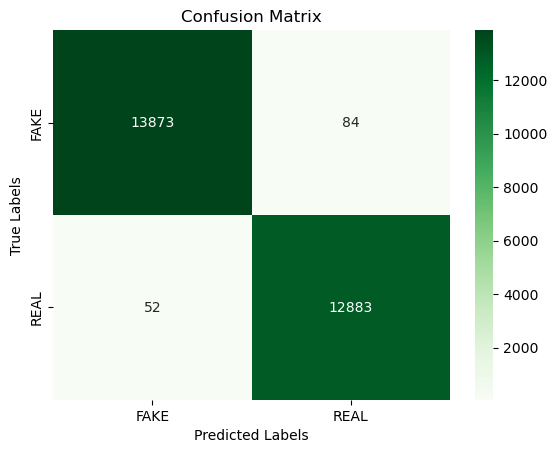

In [24]:
best_model = BERT().to(device)

load_checkpoint("./" + '/model.pt', best_model)

evaluate(best_model, test_loader)